# Part 1: Transform cascade from SBML 2 NEURON

Import pyneuroml

In [1]:
from pyneuroml import pynml

Define file name (here we use MODEL_speedy_reduced2.xml) and set required parameters

In [2]:
SBML_file_name = 'MODEL_speedy_reduced2.xml'
dur            = 1                 # ms, needed argument in neuroML. Does not change anything in the cascade.
dt             = 1                 # ms, needed argument in neuroML. Does not change anything in the cascade.

## IMPORT the SBML file using jneuroml.

This will create a new LEMS file named MODEL_speedy_reduced2_LEMS.xml (or similar if other file name is used) in the same directory

In [3]:
pynml.run_jneuroml('-sbml-import', SBML_file_name, ' '.join([str(dur), str(dt)]) )

True

## EXPORT the LEMS file into a NEURON readable .mod file.

This will create a .mod file in the same directory. <br>
The ID of the parent node in the xml file will be used as name of the mechanism.

In [4]:
base, extention = SBML_file_name.split('.')         #will not work if file name has more than one dot...
LEMS_file_name  = base + '_LEMS.' + extention

pynml.run_jneuroml('', LEMS_file_name, '-neuron')

True

## CLEAN the .mod file

The resulting .mod file will use the IDs of the substrate from the SBML file, instead of the names. <br>
This makes it very hard to read (impossible if the file is large). <br>

We therefore mapp all IDs to their respective names from the original file. <br>
We also shorten some file names to avoide errors due to long file names (e.g. reversible_reaction -> r_r)

It is likely that this will have to be custom made for each SBML file 
&nbsp; 




In [5]:
# Import lxml for parsing the SBML file
from lxml import etree

READ in the tree from the SBML file

In [6]:
tree = etree.parse(SBML_file_name)
root = tree.getroot()

EXTRACT name and id from the SBML file and EXCHANGE id for name

In [7]:
# open the .mod file resulting from the above cells (different depending on SBML file)
mod_file_name = 'D1_LTP_time_window_0.mod'
mod_file      = open(mod_file_name, 'r')
mod_file_data = mod_file.read() 

# close file
mod_file.close()

# get all species and parameter tags as well as the compartment tag (spine)
species     =  root.xpath("//*[local-name() = 'species']")
parameters  =  root.xpath("//*[local-name() = 'parameter']")
compartment =  root.xpath("//*[local-name() = 'compartment']")

for spc in species+parameters+compartment:
    
    # get name and id from tag
    name = spc.attrib['name']
    ID   = spc.attrib['id'  ]
    
    # replace non allowed characters in NEURON ('*' -> '_')
    name = name.replace('*', '_')
    
    # change id for name (if name is a single word)
    L = name.split(' ')
    
    if len(L) == 1:
        mod_file_data = mod_file_data.replace(ID, name)
        
# exchange rate__revreaction and rate__irrevreaction with rate_r and rate_ir
mod_file_data = mod_file_data.replace('rate__revreaction', 'rate_r')
mod_file_data = mod_file_data.replace('rate__irrevreaction', 'rate_ir')

# update comment
org_com = '''This NEURON file has been generated by org.neuroml.export (see https://github.com/NeuroML/org.neuroml.export)
         org.neuroml.export  v1.5.3
         org.neuroml.model   v1.5.3
         jLEMS               v0.9.9.0'''

upd_com = '''reduced speedy cascade. Connects DA conc to an excitable target (by phosphorylation)
    - automatic version created using the jupyter notebook "TRANSFORM_py_.ipynb" 
    
    - original cascade implemented and exported to SBML by Anu Nair; nair at kth . se
        based on published cascade in Nair et al., 2016 with removed dependencies and
        addition of excitable target.
    
    - transformation from SBML to mod by Robert Lindroos; robert . lindroos at ki . se
        and Daniel Keller; daniel . keller at epfl . ch
        using pyNeuroML.
        This mod file was further "cleaned" after pyNeuroML conversion:
            ~ IDs were exchanged for names
            ~ rate_revreaction   -> rate_r
            ~ rate_irrevreaction -> rate_ir 
            ~ '*'                -> '_'       (since not allowed by NEURON)

    This NEURON file has been generated by org.neuroml.export (see https://github.com/NeuroML/org.neuroml.export)
         org.neuroml.export  v1.5.3
         org.neuroml.model   v1.5.3
         jLEMS               v0.9.9.0'''

mod_file_data = mod_file_data.replace(org_com, upd_com)

# save cleaned data as test_cascade.mod
out_file = open('test_cascade.mod', 'w')
out_file.write(mod_file_data)
out_file.close()

CLEAN up directory (remove additional files created in the transformation)

In [8]:
rm D1_LTP_time_window_0.mod MODEL_speedy_reduced2_LEMS*

## compile NEURON mechanisms

In [9]:
!nrnivmodl

Creating x86_64 directory for .o files.

/home/HDD-drive/Desktop/Notebook
ampa.mod bk.mod cadyn.mod cal12.mod cal13.mod caldyn.mod can.mod caq.mod car.mod cat32.mod cat33.mod cav32.mod cav33.mod gaba.mod kaf.mod kas.mod kdr.mod kir.mod naf.mod nmda.mod sk.mod test_cascade.mod tmgabaa.mod tmglut.mod
ampa.mod bk.mod cadyn.mod cal12.mod cal13.mod caldyn.mod can.mod caq.mod car.mod cat32.mod cat33.mod cav32.mod cav33.mod gaba.mod kaf.mod kas.mod kdr.mod kir.mod naf.mod nmda.mod sk.mod test_cascade.mod tmgabaa.mod tmglut.mod
"/home/HDD-drive/neuron/nrn/x86_64/bin/nocmodl" ampa
Translating ampa.mod into ampa.c
Thread Safe
"/home/HDD-drive/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/HDD-drive/neuron/nrn/include/nrn" -I"/home/HDD-drive/neuron/nrn/x86_64/lib"      -g -O2 -c -o ampa.lo ampa.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/HDD-drive/neuron/nrn/include/nrn -I/home/HDD-drive/neuron/nrn/x86_64/lib -g -O2 -c ampa.c  -fPIC 

# Part 2; TEST the cascade in a model

IMPORT libraries

In [10]:
from __future__ import print_function, division
import sys
import json
import numpy as np
from neuron import h
from math import exp
from joblib import Parallel, delayed
import multiprocessing
import matplotlib.pyplot as plt

define default default values for input files:

TODO: these should preferably be added by the user/added here directly

In [11]:
mod        = "./mod/"
defparams  = "./params-msn.json"
morphology = "./morphology/"

h.nrn_load_dll(mod + 'x86_64/.libs/libnrnmech.so')
h.load_file('stdlib.hoc')
h.load_file('import3d.hoc')

with open('./substrates.json') as file:
    SUBSTRATES = json.load(file)

## def functions

In [12]:
#calculate_distribution(d3, dist, a4, a5, a6, a7, g8)
def calculate_distribution(d3, dist, a4, a5, a6, a7, g8):
    # d3 is the distribution type:
    #     0 linear, 1 sigmoid, 2 exponential
    #     3 step for absolute distance (in microns)
    # dist is the somatic distance
    # a4-7 is distribution parameters 
    # g8 is the maximal conductance
    if   d3 == 0: 
        value = a4 + a5*dist
    elif d3 == 1: 
        value = a4 + a5/(1 + exp((dist-a6)/a7) )
    elif d3 == 2: 
        value = a4 + a5*exp((dist-a6)/a7)
    elif d3 == 3:
        if (dist > a6) and (dist < a7):
            value = a4
        else:
            value = a5
            
    if value < 0:
        value = 0
        
    value = value*g8
    return value 

In [13]:
def alpha(tstart, gmax, tau):
    '''calc and returns a "magnitude" using an alpha function''' 
    
    v = 1 - (h.t - tstart) / tau
    e = exp(v)
    mag = gmax * (h.t - tstart) / tau * e
    
    return mag

In [14]:
def calc_rand_Modulation(mod_list, range_list=False, distribution='centered'):
    '''
    calc random modulation values between 0 and 2 (i.e. max +/- 100%).
    
    Values close to 1 (no mod) are given higer probability.
    this is achived by drawing two uniform random numbers between 0 and 1, and subtracts one from the other.
    This gives values ranging from -1 to 1. By adding one we end upp at the wanted value.
    
    If a range_list is supplied the range of the values can be shifted from [0,2] to any
    other range. The range list must have the same length as mod_list and hold lists of
    [min, max] values.
    
    '''
    
    mod_factors = []
    
    A=0
    B=2
    
    for i,channel in enumerate(mod_list):
        
        if distribution=='centered':
            factor = 1.0 + ( np.random.uniform() - np.random.uniform() )
        elif distribution=='inv_centered':
            factor = 1.0 + ( np.random.uniform() - np.random.uniform() )
            if factor <= 1:
                factor = factor + 1.0
            else:
                factor = factor - 1.0
        elif distribution=='uniform':
            factor = 2.0 * np.random.uniform()
        else:
            print('Error in MF distribution--line ~121')
            eegsjsd
        
        
        if range_list:
            
            a       = range_list[i][0]
            b       = range_list[i][1]
            
            factor = (b-a) / (B-A) * (factor-A) + a
       
        mod_factors.append(factor)
        
    return mod_factors 

In [15]:
def make_random_synapse(ns, nc, Syn, sec, x,               \
                Type='glut',                    \
                NS_start=1,                     \
                NS_interval=1000.0/18.0,        \
                NS_noise=1.0,                   \
                NS_number=1000,                 \
                S_AN_ratio=1.0,                 \
                S_tau_dep=100,                  \
                S_U=1,                          \
                S_e=-60,                        \
                S_tau1=0.25,                    \
                S_tau2=3.75,                    \
                NC_delay=1,                     \
                NC_conductance=0.6e-3,          \
                NC_threshold=0.1                ):
    
    
    # create/set synapse in segment x of section
    if Type == 'glut':
        key                 = sec
        Syn[key]            = h.tmGlut(x, sec=sec)
        Syn[key].nmda_ratio = S_AN_ratio
        Syn[key].tauR       = S_tau_dep
        Syn[key].U          = S_U
        
    elif Type in ['expSyn2', 'tmgabaa', 'gaba']:
        
        key                 = sec.name() + '_gaba'
        
        if Type == 'expSyn2':
            Syn[key]            = h.Exp2Syn(x, sec=sec)
            Syn[key].tau1       = S_tau1
            Syn[key].tau2       = S_tau2 
        elif Type == 'tmgabaa':
            Syn[key]            = h.tmGabaA(x, sec=sec)
            
        Syn[key].e          = S_e
        
         
    # create NetStim object
    ns[key]             = h.NetStim()
    ns[key].start       = NS_start
    ns[key].interval    = NS_interval # mean interval between two spikes in ms
    ns[key].noise       = NS_noise
    ns[key].number      = NS_number

    # create NetCon object
    nc[key]             = h.NetCon(ns[sec],Syn[sec])
    nc[key].delay       = NC_delay
    nc[key].weight[0]   = NC_conductance
    nc[key].threshold   = NC_threshold

In [16]:
def set_rand_synapse(channel_list, base_mod, max_mod, range_list=[[0.75,1.5],[0.75,1.5]]):   
    
    syn_fact = calc_rand_Modulation(channel_list, range_list=range_list, distribution='uniform')
        
    # normalize factors to max-value of pointer substrate
    normalized_factors     = []
    for i,mech in enumerate(channel_list):
        
        normalized_factors.append( (syn_fact[i] - 1) / (max_mod - base_mod)  ) 
        
    return syn_fact, normalized_factors 

## def MSN class

In [17]:
class MSN:
    '''MSN class definition'''
    def __init__(self, params=defparams, factors=None):
        Import = h.Import3d_SWC_read()
        Import.input(morphology + 'latest_WT-P270-20-14ak.swc')
        imprt = h.Import3d_GUI(Import, 0)
        imprt.instantiate(None)
        h.define_shape()
        # h.cao0_ca_ion = 2  # default in nrn
        h.celsius = 35
        self._create_sectionlists()
        self._set_nsegs()
        self.v_init = -80
        for sec in self.allseclist:
            sec.Ra = 150
            sec.cm = 1.0
            sec.insert('pas')
            #sec.g_pas = 1e-5 # set using json file
            sec.e_pas = -70 # -73
        for sec in self.somalist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('can')
            #sec.kb_cadyn = 200.
        for sec in self.axonlist:
            sec.insert('naf')
            #sec.insert('kaf')
            sec.insert('kas')
            #sec.insert('kdr')
            #sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
        for sec in self.dendlist:
            sec.insert('naf')
            sec.insert('kaf')
            sec.insert('kas')
            sec.insert('kdr')
            sec.insert('kir')
            sec.ena = 50
            sec.ek = -85 # -90
            sec.insert('cal12')
            sec.insert('cal13')
            sec.insert('car')
            sec.insert('cadyn')
            sec.insert('caldyn')
            sec.insert('sk')
            sec.insert('bk')
            sec.insert('cat32')
            sec.insert('cat33')

        with open(params) as file:
            par = json.load(file)

        self.distribute_channels("soma", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("axon", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))
        self.distribute_channels("dend", "g_pas", 0, 1, 0, 0, 0, float(par['g_pas_all']['Value']))

        self.distribute_channels("soma", "gbar_naf", 0, 1, 0, 0, 0, float(par['gbar_naf_somatic']['Value']),factors=factors)
        self.distribute_channels("soma", "gbar_kaf", 0, 1, 0, 0, 0, float(par['gbar_kaf_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kas", 0, 1, 0, 0, 0, float(par['gbar_kas_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_somatic']['Value']))
        self.distribute_channels("soma", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_somatic']['Value']))
        self.distribute_channels("soma", "gbar_sk", 0, 1, 0, 0, 0, float(par['gbar_sk_somatic']['Value']))
        self.distribute_channels("soma", "gbar_bk", 0, 1, 0, 0, 0, float(par['gbar_bk_somatic']['Value']))
        
        #self.distribute_channels("axon", "gbar_naf", 0, 1, 0, 0, 0, float(par['gbar_naf_somatic']['Value']),factors=factors)
        self.distribute_channels("axon", "gbar_naf", 3, 1, 1.1, 30, 500, float(par['gbar_naf_axonal']['Value']),factors=factors)
        #self.distribute_channels("axon", "gbar_naf", 3, 1, 1.1, 20, 500, float(par['gbar_naf_axonal']['Value']))
        #self.distribute_channels("dend", "gbar_naf", 1, 1,  1.2, 30, -5, float(par['gbar_naf_axonal']['Value']))
        self.distribute_channels("axon", "gbar_kas", 0, 1, 0, 0, 0, float(par['gbar_kas_axonal']['Value']))
        
        self.distribute_channels("dend", "gbar_naf", 1, 0.1, 0.9, 60.0, 10.0, float(par['gbar_naf_basal']['Value']),factors=factors)
        self.distribute_channels("dend", "gbar_kaf", 1, 1,  0.5, 120, -30, float(par['gbar_kaf_basal']['Value']))
        #self.distribute_channels("dend", "gbar_naf", 0, 1, -0.0072, 0, 0, float(par['gbar_naf_basal']['Value']))
        #self.distribute_channels("dend", "gbar_kaf", 0, 1,  0.0167, 0, 0, float(par['gbar_kaf_basal']['Value']))
        self.distribute_channels("dend", "gbar_kas", 2, 1, 9.0, 0.0, -5.0, float(par['gbar_kas_basal']['Value']))
        self.distribute_channels("dend", "gbar_kdr", 0, 1, 0, 0, 0, float(par['gbar_kdr_basal']['Value']))
        self.distribute_channels("dend", "gbar_kir", 0, 1, 0, 0, 0, float(par['gbar_kir_basal']['Value']))
        self.distribute_channels("dend", "gbar_sk", 0, 1, 0, 0, 0, float(par['gbar_sk_basal']['Value']))
        self.distribute_channels("dend", "gbar_bk", 0, 1, 0, 0, 0, float(par['gbar_bk_basal']['Value']))

        self.distribute_channels("soma", "pbar_cal12", 0, 1, 0, 0, 0, 1e-5)
        self.distribute_channels("soma", "pbar_cal13", 0, 1, 0, 0, 0, 1e-6)
        self.distribute_channels("soma", "pbar_car", 0, 1, 0, 0, 0, 1e-4)
        self.distribute_channels("soma", "pbar_can", 0, 1, 0, 0, 0, 3e-5)
        #self.distribute_channels("soma", "kb_cadyn", 0, 1, 0, 0, 0, 200.0)
        self.distribute_channels("dend", "pbar_cal12", 0, 1, 0, 0, 0, 1e-5)
        self.distribute_channels("dend", "pbar_cal13", 0, 1, 0, 0, 0, 1e-6)
        self.distribute_channels("dend", "pbar_car", 0, 1, 0, 0, 0, 1e-4)
        self.distribute_channels("dend", "pbar_cat32", 1, 0, 1.0, 70.0, -4.5, 1e-7)
        self.distribute_channels("dend", "pbar_cat33", 1, 0, 1.0, 70.0, -4.5, 1e-8)

    def _create_sectionlists(self):
        self.allsecnames = []
        self.allseclist = h.SectionList()
        for sec in h.allsec():
            self.allsecnames.append(sec.name())
            self.allseclist.append(sec=sec)
        self.nsomasec = 0
        self.somalist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('soma') >= 0:
                self.somalist.append(sec=sec)
                if self.nsomasec == 0:
                    self.soma = sec
                self.nsomasec += 1
        self.axonlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('axon') >= 0:
                self.axonlist.append(sec=sec)
        self.dendlist = h.SectionList()
        for sec in h.allsec():
            if sec.name().find('dend') >= 0:
                self.dendlist.append(sec=sec)

    def _set_nsegs(self):
        for sec in self.allseclist:
            sec.nseg = 2*int(sec.L/40.0)+1
        for sec in self.axonlist:
            sec.nseg = 2  # two segments in axon initial segment

    def _max_dist(self, axon_excluding=True):
        h.distance(sec=self.soma)
        dmax = 0
        for sec in self.allseclist:
            if axon_excluding and sec.name().find('axon') == 0: continue
            dmax = max(dmax, h.distance(1, sec=sec))
        return dmax

    def distribute_channels(self, as1, as2, d3, a4, a5, a6, a7, g8, factors=None):
        h.distance(sec=self.soma)
        dmax = self._max_dist()
        for sec in self.allseclist:
            if sec.name().find(as1) >= 0:
                for seg in sec:
                    dist = h.distance(seg.x, sec=sec)
                    val = calculate_distribution(d3, dist, a4, a5, a6, a7, g8)
                    cmd = 'seg.%s = %g' % (as2, val)
                    exec(cmd)

## main function

In [18]:
def main(par="./params-msn.json", \
                            sim='vm',       \
                            amp=0.265,      \
                            run=None,       \
                            modulation=1,   \
                            simDur=7000,    \
                            stimDur=900,    \
                            factors=None,   \
                            section=None,   \
                            randMod=None,   \
                            testMode=False, \
                            target=None,    \
                            chan2mod=['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can'] ): 
    
    
    
    print(locals())
    
    # initiate cell
    cell = MSN(params=par, factors=factors)
        
    # set cascade ---- move to MSN def?
    casc = h.D1_LTP_time_window_0(0.5, sec=cell.soma) # other cascades also possible...
    
    if target:
        cmd = 'pointer = casc._ref_'+target
        exec(cmd)
        
        base_mod    = SUBSTRATES[target][0]
        max_mod     = SUBSTRATES[target][1]
        
    else:
        pointer     = casc._ref_Target1p    #Target1p   #totalActivePKA    (if full cascade used)
        base_mod    = casc.init_Target1p
        max_mod     = 2317.1
    
    # set edge of soma as reference for distance 
    h.distance(1, sec=h.soma[0])
    
    # set current injection
    stim = h.IClamp(0.5, sec=cell.soma)
    stim.amp = amp  
    stim.delay = 100
    stim.dur = stimDur            # 2ms 2nA to elicit single AP, following Day et al 2008 Ca dyn    
    
    # record vectors
    tm = h.Vector()
    tm.record(h._ref_t)
    vm = h.Vector()
    vm.record(cell.soma(0.5)._ref_v)
    
    # substrates
    pka = h.Vector()
    pka.record(casc._ref_Target1p)
    camp = h.Vector()
    camp.record(casc._ref_cAMP)
    gprot = h.Vector()
    gprot.record(casc._ref_D1RDAGolf) #D1RDAGolf
    gbg   = h.Vector()
    gbg.record(casc._ref_Gbgolf) #Gbgolf
    da = h.Vector()
    da.record(casc._ref_DA)
    
    # peak n dipp parameters
    da_peak   = 500   # concentration [nM]
    da_tstart = 1000    # stimulation time [ms]
    da_tau    = 500    # time constant [ms]
    
    
    tstop = simDur               # [ms]
    
    
    # all channels to modulate
    mod_list = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can' ]
    
    
    not2mod = [] #['kaf']
    
    
    # find channels that should not be modulated
    for chan in mod_list:
        
        if chan not in chan2mod:
            
            not2mod.append(chan)
    
    
    # for random modulation: modValues = np.arange(0.1, 2.0, 0.1) -------------------------
    if randMod == 1:
        
        # new factors every run
        mod_fact = calc_rand_Modulation(mod_list, range_list=[[0.60,0.80],    \
                                                              [0.65,0.85],  \
                                                              [0.75,0.85],  \
                                                              [0.85,1.25],  \
                                                              [1.0,2.0],    \
                                                              [1.0,2.0],    \
                                                              [0.0,1.0]],
                                                              distribution='uniform'  )
        
    else:
        mod_fact = [ 0.8, 0.8, 0.8, 1.25, 2.0, 2.0, 0.5  ]
    
    print()
    print('--- Intrinsic modulation factors ---')
    print(chan2mod)
    print(mod_fact)
    
    # normalize factors to  target values seen in simulation
    factors     = []
    for i,mech in enumerate(mod_list):
        
        factor  = (mod_fact[i] - 1) / (max_mod - base_mod) #2317.1
        
        factors.append(factor)
        
        #print(mech, mod_fact[i], factor) # --------------------------------------------------------
            
    
    # set pointers 
    for sec in h.allsec():
        
        for seg in sec:
            
            # naf and kas is in all sections
            h.setpointer(pointer, 'pka', seg.kas )
            h.setpointer(pointer, 'pka', seg.naf )
            
            if sec.name().find('axon') < 0:    
                
                # these channels are not in the axon sections
                
                h.setpointer(pointer, 'pka', seg.kaf )
                h.setpointer(pointer, 'pka', seg.cal12 )
                h.setpointer(pointer, 'pka', seg.cal13 )
                h.setpointer(pointer, 'pka', seg.kir )
                #h.setpointer(pointerc, 'pka', seg.car )
                
                if sec.name().find('soma') >= 0:
                    
                    # can is only distributed to the soma section
                    h.setpointer(pointer, 'pka', seg.can )
                    
                    
    
    # synaptic modulation ================================================================
    if sim == 'synMod':
        
        
        # draw random modulation factors (intervals given by range_list[[min,max]]  
        glut_f, glut_f_norm     = set_rand_synapse(['amp', 'nmd'], base_mod, max_mod,   \
                                                    range_list=[[0.9,1.6], [0.9,1.6]]   )
                                                    
        gaba_f, gaba_f_norm     = set_rand_synapse(['gab'],        base_mod, max_mod,   \
                                                    range_list=[[0.6,1.4]]              )
        
        syn_fact = glut_f + gaba_f
        
        print()
        print('--- Synaptic factors ----')
        print(['amp', 'nmd']+['gab'])
        print(syn_fact)
            
        I_d={}
        
        ns = {}
        nc = {}
        Syn = {}
        for sec in h.allsec():
            if sec.name().find('dend') >= 0:
                
                # create a glut synapse
                make_random_synapse(ns, nc, Syn, sec, 0.5,          \
                                        NS_interval=1000.0/17.0,    \
                                        NC_conductance=0.15e-3,     \
                                        S_tau_dep=100               )
                                        
                # create a gaba synapse
                make_random_synapse(ns, nc, Syn, sec, 0.0,          \
                                        Type='tmgabaa',             \
                                        NS_interval=1000.0/4.0,     \
                                        NC_conductance=0.45e-3      )
                
                # set pointer(s)
                h.setpointer(pointer, 'pka', Syn[sec])
                h.setpointer(pointer, 'pka', Syn[sec.name()+'_gaba'])
                
                # set (random?) modulation
                Syn[sec].base    = base_mod
                
                #randMod?
                if randMod == 1:
                    Syn[sec].f_ampa     = glut_f_norm[0]
                    Syn[sec].f_nmda     = glut_f_norm[1]
                else:
                    Syn[sec].f_ampa     = 0
                    Syn[sec].f_nmda     = 0
                
                if randMod == 1:
                    Syn[sec.name()+'_gaba'].base    = base_mod
                    Syn[sec.name()+'_gaba'].f_gaba  = gaba_f_norm[0]
                else:
                    Syn[sec.name()+'_gaba'].f_gaba  = 0
            
            
            elif sec.name().find('axon') >= 0: 
                continue   
            
            if randMod == 1:
                for seg in sec:
                    
                    for mech in seg:
                        
                        if mech.name() in not2mod:
                            
                            mech.factor = 0.0
                            print(mech.name(), 'and channel:', not2mod, mech.factor, sec.name())
                            
                        elif mech.name() in mod_list:
                        
                            mech.base       = base_mod
                            index           = mod_list.index( mech.name() )
                            mech.factor     = factors[index]
                    
                    
                    
                    
    
    # solver------------------------------------------------------------------------------            
    cvode = h.CVode()
    
    h.finitialize(cell.v_init)
    
    # run simulation
    while h.t < tstop:
    
        if modulation == 1:
        
            if h.t > da_tstart: 
                
                # set DA and ACh values (using alpha function)
                casc.DA = alpha(da_tstart, da_peak, da_tau) 
                #casc.ACh = ach_base - alpha(ach_tstart, ach_base, ach_tau)
                
        h.fadvance()
        
    # plot result --------------------------------------------------------------------------------
    try:
        import matplotlib.pyplot as plt

        # fig 1
        plt.plot(tm, vm)         

        # fig 2
        plt.figure()
        plt.plot(tm, np.divide(da,max(da)))
        plt.plot(tm, np.divide(gprot,max(gprot)))
        plt.plot(tm, np.divide(gbg,max(gbg)))
        plt.plot(tm, np.divide(camp,max(camp)))
        plt.plot(tm, np.divide(pka,max(pka))) 
        plt.legend(['da', 'gprot', 'gbg', 'camp', 'pka'], loc='best')

        plt.show()

    except ImportError:
        print('no matplotlib available')
        
        

## Run simulation

{'par': './params-rob.json', 'run': None, 'target': 'Target1p', 'factors': None, 'modulation': 1, 'section': None, 'stimDur': 3000, 'chan2mod': ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can'], 'simDur': 2000, 'testMode': False, 'randMod': 1, 'amp': 0.0, 'sim': 'synMod'}

--- Intrinsic modulation factors ---
['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can']
[0.7767973730786708, 0.7301964162923315, 0.7525022527998952, 0.8652262814994733, 1.3064871683755204, 1.2313680332396997, 0.20685330244859668]

--- Synaptic factors ----
['amp', 'nmd', 'gab']
[1.452231099657812, 1.0590033190739863, 0.765033362085102]


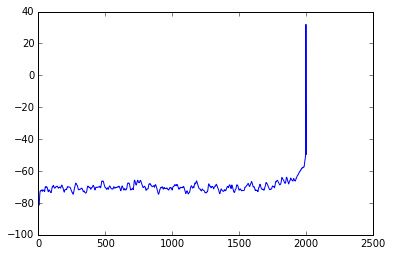

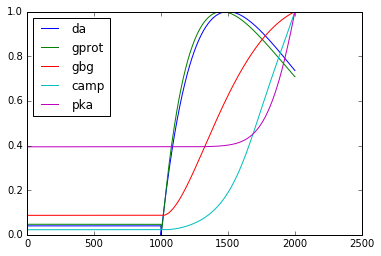

In [19]:
main( par="./params-rob.json",          \
            amp=0.0,                    \
            simDur=2000,                \
            stimDur=3000,               \
            sim='synMod',               \
            modulation=1,               \
            randMod=1,                  \
            target='Target1p')
